### This notebook is dedicated to the data scientist challenge for city council of New York City 

In [6]:
from __future__ import print_function, division
import pandas as pd
import numpy as np
import pymannkendall as mk
import seaborn as sns
import os
import requests
import shapely
import json

import io
from fiona.crs import from_epsg
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats
import urllib
import requests
import glob
import geopandas as gpd

### Table of Contents:
* [ Data Preparation - The NYPD Arrests Data Set (Historic)](#1)
* [Feature Engineering](#2)
* [Exploratory Analysis](#3)
    * [Total number of arrest changes of 2015 - 2018](#3.1)
    * [Top 5 most frequent arrests as described in the column 'pd_desc' in 2018](#3.2)
    * [is there more crime in precinct 19 (Upper East Side) than precinct 73 (Brownsville)?](#3.3)
    * [Arrest number weekday vs. weekend](#3.4)
    * [Arrest changes over time in each borough from 2015 - 2018](#3.5)
    * [The number of arrest for the level of offense ](#3.6)
    * [ The number of arrest for the level of offense ](#3.7)


<a id='1'></a>
## 1. Data Preparation - The NYPD Arrests Data Set (Historic)

In [7]:
crime= pd.read_csv("https://data.cityofnewyork.us/api/views/8h9b-rp9u/rows.csv?accessType=DOWNLOAD")

In [8]:
crime.shape

(4798339, 18)

In [9]:
crime['ARREST_DATE']=pd.to_datetime(crime.ARREST_DATE)

In [10]:
# Extract year and month information from the arrest_date record 
crime['year'] = pd.DatetimeIndex(crime['ARREST_DATE']).year
crime['month'] = pd.DatetimeIndex(crime['ARREST_DATE']).month

In [11]:
# Fliter the data to only from 2015 - 2018
crime_1518 = crime[crime.year.isin([2015,2016,2017,2018])]
crime_1518.head()

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,year,month
0,173130602,2017-12-31,566.0,"MARIJUANA, POSSESSION",678.0,MISCELLANEOUS PENAL LAW,PL 2210500,V,Q,105,0.0,25-44,M,BLACK,1063056.0,207463.0,40.735772,-73.715638,2017,12
1,173114463,2017-12-31,478.0,"THEFT OF SERVICES, UNCLASSIFIED",343.0,OTHER OFFENSES RELATED TO THEFT,PL 1651503,M,Q,114,0.0,25-44,M,ASIAN / PACIFIC ISLANDER,1009113.0,219613.0,40.769437,-73.910241,2017,12
2,173113513,2017-12-31,849.0,"NY STATE LAWS,UNCLASSIFIED VIOLATION",677.0,OTHER STATE LAWS,LOC000000V,V,K,73,1.0,18-24,M,BLACK,1010719.0,186857.0,40.679525,-73.904572,2017,12
3,173113423,2017-12-31,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,M,18,0.0,25-44,M,WHITE,987831.0,217446.0,40.763523,-73.987074,2017,12
4,173113421,2017-12-31,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,M,18,0.0,45-64,M,BLACK,987073.0,216078.0,40.759768,-73.989811,2017,12


<a id='2'></a>
## 2. Feature Engineering

In [ ]:
## check null
crime_1518.isnull().sum()

In [ ]:
# Replace the full borough name
crime_1518.ARREST_BORO.replace(['Q', 'K', 'M', 'S', 'B'], ['Queen','Brooklyn','Manhattan', 'Staten_Island','Bronx'], inplace=True)

In [ ]:
# clean age group column
crime['AGE_GROUP'].value_counts()

In [ ]:
x = ['25-44','18-24', '45-64','<18','65+']
crime['AGE_GROUP'] = crime['AGE_GROUP'].apply(lambda i: 'unknown' if i not in x else i)

In [ ]:
crime['AGE_GROUP'].value_counts()

<a id='3'></a>
## 3. Exploratory Analysis 

<a id='3.1'></a>
### 3.1 Total number of arrest changes of 2015 - 2018


In [18]:
df_rate = crime.groupby([crime['ARREST_DATE'].dt.year]).count()

In [19]:
df_rate= df_rate[['ARREST_KEY']]
df_rate = df_rate.rename(columns={"ARREST_KEY": "ARREST_COUNT"})

In [30]:
# choose the data from 2015 - 2018
df_rate_1518 = df_rate.loc['2015':'2018']
df_rate_1518.reset_index()

,ARREST_DATE,ARREST_COUNT
0,2015,339470
1,2016,314864
2,2017,286225
3,2018,246773


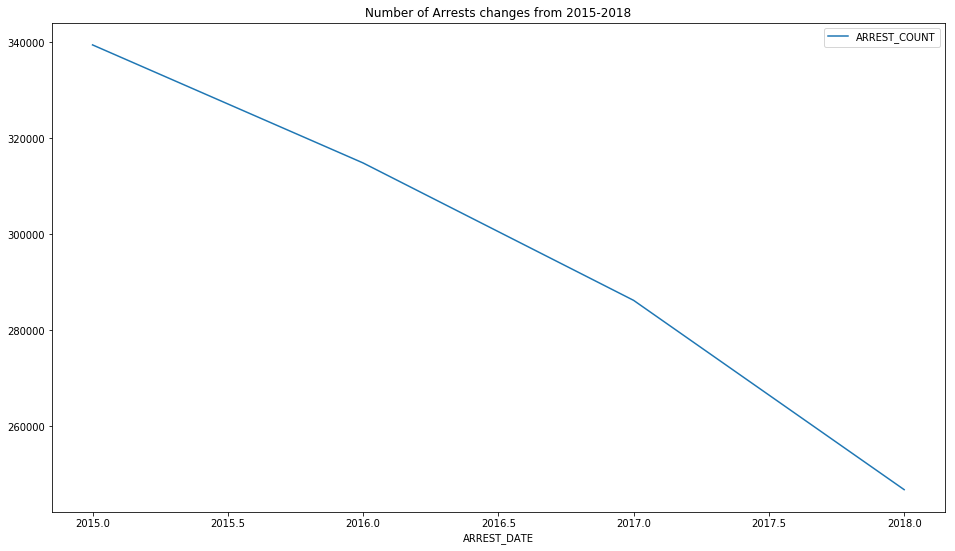

In [31]:
df_rate_1518.plot(figsize=(16, 9), title='Number of Arrests changes from 2015-2018');

plt.ticklabel_format(style='plain', axis='y')

In [35]:
#find the OLS coefficient using numpy, 
#Since the coefficient on the trend variable is negative,observations in your variable are decreading over time.

y = df_rate_1518.ARREST_COUNT.values

x = []
x.append(range(len(y)))                 
x.append([1 for ele in range(len(y))]) 

y = np.matrix(y).T
x = np.matrix(x).T

betas = ((x.T*x).I*x.T*y)

In [36]:
betas

matrix([[-30673. ],
        [342842.5]])

<a id='3.2'></a>
### 3.2 Top 5 most frequent arrests as described in the column 'pd_desc' in 2018 .Compare & describe the overall trends of these arrests across time.


In [12]:
crime_2018 = crime.loc[crime['year'] == 2018]

In [13]:
crime_2018.shape

(246773, 20)

In [14]:
crime_type_2018 = crime_2018.groupby([crime['PD_DESC']]).count()
crime_type_2018.head()

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,year,month
PD_DESC,,,,,,,,,,,,,,,,,,,,
"A.B.C.,FALSE PROOF OF AGE",12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12
ABORTION 1,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
"ACCOSTING,FRAUDULENT",141,141,141,141,141,141,141,141,141,141,141,141,141,141,141,141,141,141,141,141
"ADM.CODE,UNCLASSIFIED MISDEMEA",23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23
"ADM.CODE,UNCLASSIFIED VIOLATIO",145,145,145,145,145,145,145,145,145,145,145,145,145,145,145,145,145,145,145,145


In [15]:
crime_type_2018.sort_values(by='ARREST_KEY',ascending=False,inplace= True)
crime_type_2018= crime_type_2018[['ARREST_KEY']]
crime_type_2018 = crime_type_2018.rename(columns={"ARREST_KEY": "ARREST_COUNT"})

In [16]:
crime_type_2018 = crime_type_2018.head(5)

In [17]:
crime_type_2018.reset_index()

,PD_DESC,ARREST_COUNT
0,ASSAULT 3,26611
1,"LARCENY,PETIT FROM OPEN AREAS,UNCLASSIFIED",23405
2,"TRAFFIC,UNCLASSIFIED MISDEMEAN",14856
3,"ASSAULT 2,1,UNCLASSIFIED",11763
4,"CONTROLLED SUBSTANCE, POSSESSION 7",9982


#### The top 5 arrest in 2018 are: "ASSAULT 3", "LARCENY,PETIT FROM OPEN AREAS,UNCLASSIFIED	", "TRAFFIC,UNCLASSIFIED MISDEMEAN	", "ASSAULT 2,1,UNCLASSIFIED	", "CONTROLLED SUBSTANCE, POSSESSION 7	"

In [19]:
# Top5 arrest changes in different months in 2018 
crime_top18 = crime_2018[crime_2018.PD_DESC.isin(['LARCENY,PETIT FROM OPEN AREAS,UNCLASSIFIED','ASSAULT 3','TRAFFIC,UNCLASSIFIED MISDEMEAN','ASSAULT 2,1,UNCLASSIFIED','CONTROLLED SUBSTANCE, POSSESSION 7'])]
crime_top18.head()

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,year,month
4551570,191704095,2018-12-31,339.0,"LARCENY,PETIT FROM OPEN AREAS,UNCLASSIFIED",341.0,PETIT LARCENY,PL 1552500,M,K,67,0.0,25-44,M,BLACK,1004500.0,180655.0,40.662518,-73.927012,2018,12
4551575,191699348,2018-12-31,922.0,"TRAFFIC,UNCLASSIFIED MISDEMEAN",348.0,VEHICLE AND TRAFFIC LAWS,VTL0511001,M,B,44,0.0,45-64,M,UNKNOWN,1007617.0,241317.0,40.829012,-73.915566,2018,12
4551576,191698303,2018-12-31,339.0,"LARCENY,PETIT FROM OPEN AREAS,UNCLASSIFIED",341.0,PETIT LARCENY,PL 1552500,M,Q,103,0.0,45-64,F,ASIAN / PACIFIC ISLANDER,1040436.0,195998.0,40.704476,-73.797356,2018,12
4551579,191702396,2018-12-31,339.0,"LARCENY,PETIT FROM OPEN AREAS,UNCLASSIFIED",341.0,PETIT LARCENY,PL 1552500,M,Q,113,0.0,45-64,M,BLACK,1050434.0,186942.0,40.679550,-73.761385,2018,12
4551580,191692028,2018-12-31,339.0,"LARCENY,PETIT FROM OPEN AREAS,UNCLASSIFIED",341.0,PETIT LARCENY,PL 1552500,M,M,14,0.0,18-24,F,BLACK,987220.0,212676.0,40.750431,-73.989282,2018,12


In [20]:
crime_type_2018_month = crime_top18.groupby([crime_top18['month'],crime_top18['PD_DESC']]).count()


In [21]:
crime_month= crime_type_2018_month[['ARREST_KEY']]
crime_month = crime_type_2018_month.rename(columns={"ARREST_KEY": "ARREST_COUNT"})

In [22]:
df_pivot_month = crime_month.reset_index()
df_pivot_month = df_pivot_month.pivot(index='month', columns='PD_DESC', values='ARREST_COUNT')
df_pivot_month.head()

PD_DESC,"ASSAULT 2,1,UNCLASSIFIED",ASSAULT 3,"CONTROLLED SUBSTANCE, POSSESSION 7","LARCENY,PETIT FROM OPEN AREAS,UNCLASSIFIED","TRAFFIC,UNCLASSIFIED MISDEMEAN"
month,,,,,
1,946,2182,902,1940,1782
2,898,2115,940,1847,1539
3,974,2347,911,1945,1558
4,958,2226,823,1928,1307
5,1060,2442,817,2038,1256


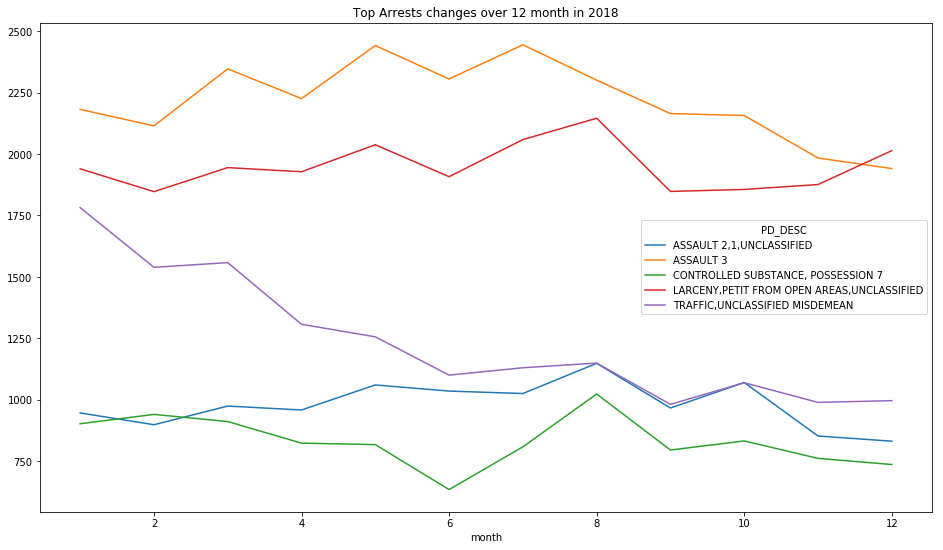

In [23]:
df_pivot_month.plot(figsize=(16, 9), title='Top Arrests changes over 12 month in 2018');

plt.ticklabel_format(style='plain', axis='y')

In [24]:
### The top arrest changes and trend overtime in different years 

In [25]:
# Fliter whole arrest dataset by the top 5 arrests in New York City in 2018
crime_top = crime[crime.PD_DESC.isin(['LARCENY,PETIT FROM OPEN AREAS,UNCLASSIFIED','ASSAULT 3','TRAFFIC,UNCLASSIFIED MISDEMEAN','ASSAULT 2,1,UNCLASSIFIED','CONTROLLED SUBSTANCE, POSSESSION 7'])]
crime_top.head()

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,year,month
3,173113423,2017-12-31,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,M,18,0.0,25-44,M,WHITE,987831.0,217446.0,40.763523,-73.987074,2017,12
4,173113421,2017-12-31,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,M,18,0.0,45-64,M,BLACK,987073.0,216078.0,40.759768,-73.989811,2017,12
6,173129349,2017-12-31,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,M,9,0.0,18-24,F,WHITE HISPANIC,990592.0,202391.0,40.722199,-73.977122,2017,12
7,173128438,2017-12-31,511.0,"CONTROLLED SUBSTANCE, POSSESSION 7",235.0,DANGEROUS DRUGS,PL 2200300,M,M,25,0.0,25-44,M,BLACK,999724.0,230625.0,40.799683,-73.944112,2017,12
8,173128437,2017-12-31,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,M,23,2.0,25-44,M,BLACK HISPANIC,998165.0,226184.0,40.787496,-73.949752,2017,12


In [26]:
crime_year = crime_top.groupby([crime_top['year'],crime_top['PD_DESC']]).count()

In [27]:
crime_year= crime_year[['ARREST_KEY']]
crime_year = crime_year.rename(columns={"ARREST_KEY": "ARREST_COUNT"})

In [28]:
crime_year.head()

ARREST_COUNT
year PD_DESC                                                 
2006 ASSAULT 2,1,UNCLASSIFIED                           10932
     ASSAULT 3                                          26613
     CONTROLLED SUBSTANCE, POSSESSION 7                 27752
     LARCENY,PETIT FROM OPEN AREAS,UNCLASSIFIED          5760
     TRAFFIC,UNCLASSIFIED MISDEMEAN                        87

In [29]:
crime_year.index.levels

FrozenList([[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018], ['ASSAULT 2,1,UNCLASSIFIED', 'ASSAULT 3', 'CONTROLLED SUBSTANCE, POSSESSION 7', 'LARCENY,PETIT FROM OPEN AREAS,UNCLASSIFIED', 'TRAFFIC,UNCLASSIFIED MISDEMEAN']])

In [30]:
df_pivot = crime_year.reset_index()
df_pivot = df_pivot.pivot(index='year', columns='PD_DESC', values='ARREST_COUNT')
df_pivot.head()

PD_DESC,"ASSAULT 2,1,UNCLASSIFIED",ASSAULT 3,"CONTROLLED SUBSTANCE, POSSESSION 7","LARCENY,PETIT FROM OPEN AREAS,UNCLASSIFIED","TRAFFIC,UNCLASSIFIED MISDEMEAN"
year,,,,,
2006,10932,26613,27752,5760,87
2007,11600,28694,30497,6204,517
2008,11414,28800,29400,7617,74
2009,11151,30070,26400,7850,158
2010,11325,31809,22725,8051,274


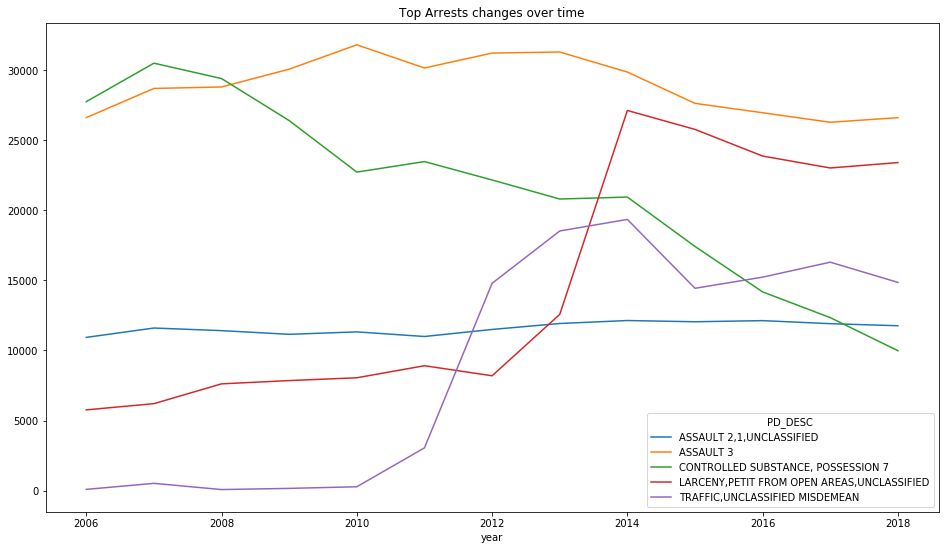

In [31]:
df_pivot.plot(figsize=(16, 9), title='Top Arrests changes over time');

plt.ticklabel_format(style='plain', axis='y')

<a id='3.3'></a>
### 3.3 If we think of arrests as a sample of total crime, is there more crime in precinct 19 (Upper East Side) than precinct 73 (Brownsville)? Describe the trend, variability and justify any statistical tests used to support this conclusion.

In [32]:
# Use data from 2015 - 2018 to fliter the record only in precinct 19 and 93
crime_type = crime_1518 [crime_1518.ARREST_PRECINCT.isin(['19','73'])]

In [33]:
crime_type= crime_type.replace({19: "Upper_East_Side", 73: "Brownsville"})

In [34]:
crime_type.shape

(39451, 20)

In [35]:
crime_type_group1 = crime_type.groupby(crime_type['ARREST_PRECINCT']).count()
crime_type_group1.head()

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,year,month
ARREST_PRECINCT,,,,,,,,,,,,,,,,,,,
Brownsville,28504,28504,28500,28465,28465,28465,28501,28462,28504,28504,28504,28504,28504,28504,28504,28504,28504,28504,28504
Upper_East_Side,10947,10947,10946,10923,10923,10923,10946,10930,10947,10947,10947,10947,10947,10947,10947,10947,10947,10947,10947


In [36]:
crime_type_group1 = crime_type_group1[['ARREST_KEY']]
crime_type_group1.rename(columns={"ARREST_KEY": "ARREST_COUNT"})

,ARREST_COUNT
ARREST_PRECINCT,
Brownsville,28504
Upper_East_Side,10947


In [37]:
crime_type_group2 = crime_type.groupby([crime_type['year'],crime_type['ARREST_PRECINCT']]).count()

In [38]:
crime_type_group2 = crime_type_group2[['ARREST_KEY']]
crime_type_group2 = crime_type_group2.rename(columns={"ARREST_KEY": "ARREST_COUNT"})

In [39]:
crime_type_group2.head()

ARREST_COUNT
year ARREST_PRECINCT              
2015 Brownsville              8960
     Upper_East_Side          2830
2016 Brownsville              7858
     Upper_East_Side          2905
2017 Brownsville              6204

In [40]:
df_pivot_type = crime_type_group2.reset_index()
df_pivot_type = df_pivot_type.pivot(index='year', columns='ARREST_PRECINCT', values='ARREST_COUNT')
df_pivot_type

ARREST_PRECINCT,Brownsville,Upper_East_Side
year,,
2015,8960,2830
2016,7858,2905
2017,6204,2860
2018,5482,2352


In [41]:
df_pivot_type.columns

Index(['Brownsville', 'Upper_East_Side'], dtype='object', name='ARREST_PRECINCT')

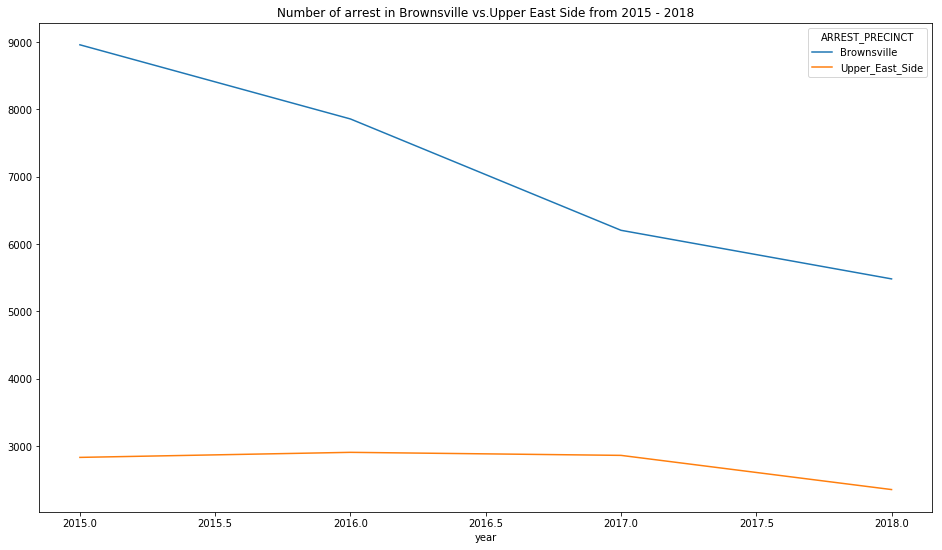

In [47]:
df_pivot_type.plot(figsize=(16, 9), title='Number of arrest in Brownsville vs.Upper East Side from 2015 - 2018');

plt.ticklabel_format(style='plain', axis='y')

In [43]:
#### Use T-test to test  whether the means of two paired samples are significantly different

In [44]:

from scipy.stats import ttest_ind

stat, p = ttest_ind(df_pivot_type.Brownsville, df_pivot_type.Upper_East_Side)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')

stat=5.496, p=0.002
Probably different distributions


#### Use Analysis of Variance Test (ANOVA) to test whether the means of two or more independent samples are significantly different.

In [45]:
from scipy.stats import f_oneway

stat, p = f_oneway(df_pivot_type.Brownsville, df_pivot_type.Upper_East_Side)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')

stat=30.211, p=0.002
Probably different distributions


#### Based on the result of two tests, we can conculde that the total arrest numbers in Brownsville is higher than Upper_East_Side

<a id='3.4'></a>
### 3.4. Arrest number weekday vs. weekend

In [48]:
crime_1518 ['weekday'] = crime_1518 ['ARREST_DATE'].dt.dayofweek
crime_1518 .head()

/Users/amber/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,...,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,year,month,weekday
0,173130602,2017-12-31,566.0,"MARIJUANA, POSSESSION",678.0,MISCELLANEOUS PENAL LAW,PL 2210500,V,Q,105,...,25-44,M,BLACK,1063056.0,207463.0,40.735772,-73.715638,2017,12,6
1,173114463,2017-12-31,478.0,"THEFT OF SERVICES, UNCLASSIFIED",343.0,OTHER OFFENSES RELATED TO THEFT,PL 1651503,M,Q,114,...,25-44,M,ASIAN / PACIFIC ISLANDER,1009113.0,219613.0,40.769437,-73.910241,2017,12,6
2,173113513,2017-12-31,849.0,"NY STATE LAWS,UNCLASSIFIED VIOLATION",677.0,OTHER STATE LAWS,LOC000000V,V,K,73,...,18-24,M,BLACK,1010719.0,186857.0,40.679525,-73.904572,2017,12,6
3,173113423,2017-12-31,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,M,18,...,25-44,M,WHITE,987831.0,217446.0,40.763523,-73.987074,2017,12,6
4,173113421,2017-12-31,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,M,18,...,45-64,M,BLACK,987073.0,216078.0,40.759768,-73.989811,2017,12,6


In [49]:
crime_1518 .weekday.replace([6, 5, 4, 3, 2, 1, 0], ['Sunday','Saturday','Friday','Thursday','Wednesday','Tuesday','Monday'], inplace=True)

/Users/amber/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [50]:
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

crime_1518 ['weekday']= crime_1518 ['weekday'].astype('category', categories=cats, ordered=True)

/Users/amber/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/amber/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [51]:
crime_week= crime_1518.groupby([crime_1518['weekday']]).count().reindex(cats) 

In [52]:
crime_week = crime_week[['ARREST_KEY']]
crime_week= crime_week.rename(columns={"ARREST_KEY": "ARREST_COUNT"})

In [53]:
crime_week.reset_index()

,weekday,ARREST_COUNT
0,Monday,136907
1,Tuesday,183716
2,Wednesday,207204
3,Thursday,198129
4,Friday,182649
5,Saturday,157731
6,Sunday,120996


No handles with labels found to put in legend.


([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text xticklabel objects>)

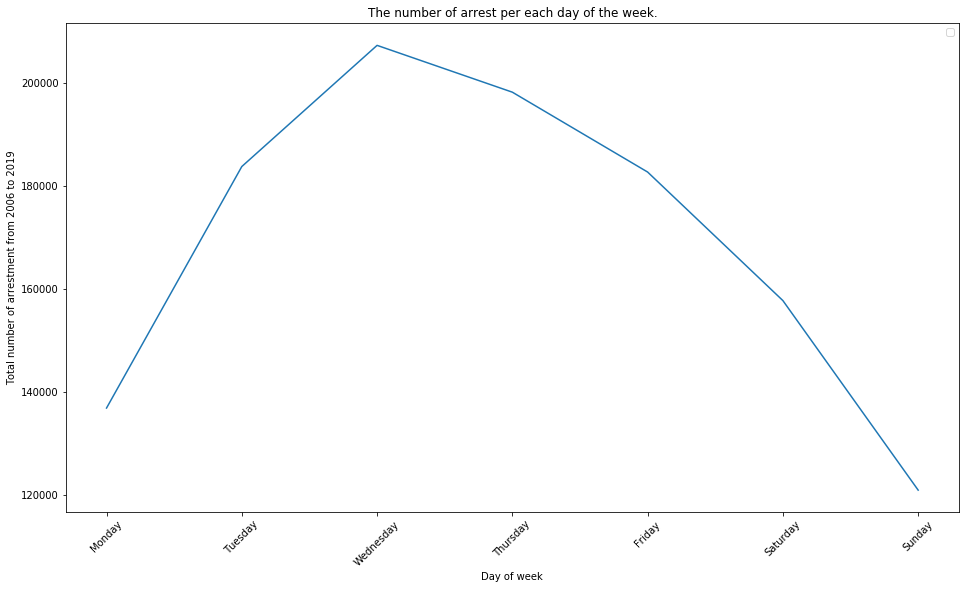

In [54]:
plt.figure(figsize=(16,9))
plt.plot(crime_week)

plt.legend()
plt.xlabel('Day of week')
plt.ylabel('Total number of arrestment from 2006 to 2019')
plt.title('The number of arrest per each day of the week.')
plt.xticks(rotation='45')

<a id='3.5'></a>
### 3.5. Arrest changes over time in each borough from 2015 - 2018

In [56]:
crime_1518.ARREST_BORO.replace(['Q', 'K', 'M', 'S', 'B'], ['Queen','Brooklyn','Manhattan', 'Staten_Island','Bronx'], inplace=True)

In [57]:
crime_boro = crime_1518.groupby(['ARREST_BORO','month']).count()

In [58]:
crime_boro = crime_boro[['ARREST_KEY']]
crime_boro= crime_boro.rename(columns={"ARREST_KEY": "ARREST_COUNT"})

In [59]:
crime_boro.head()

ARREST_COUNT
ARREST_BORO month              
Bronx       1             23078
            2             21788
            3             22925
            4             22153
            5             22676

In [60]:
df_pivot_boro = crime_boro.reset_index()
df_pivot_boro = df_pivot_boro.pivot(index='month', columns='ARREST_BORO', values='ARREST_COUNT')
df_pivot_boro.head()

ARREST_BORO,Bronx,Brooklyn,Manhattan,Queen,Staten_Island
month,,,,,
1,23078,28039,28107,19344,3765
2,21788,27490,27028,19091,3604
3,22925,30214,28557,21117,3897
4,22153,29075,27747,20392,3851
5,22676,28981,27568,20627,4051


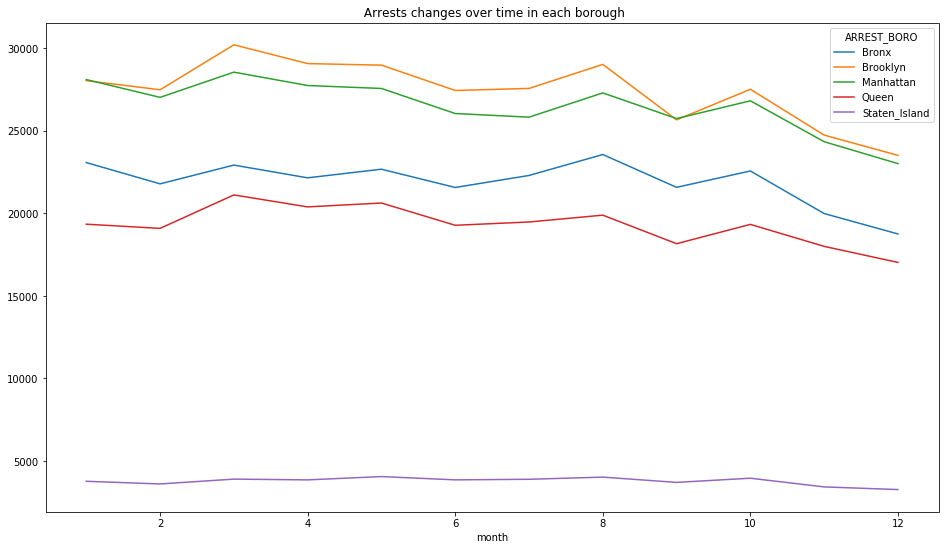

In [74]:
df_pivot_boro.plot(figsize=(16, 9), title='Arrests changes over time in each borough');

plt.ticklabel_format(style='plain', axis='y')

<a id='3.6'></a>
### 3.6. The number of arrest for the level of offense 

In [68]:
crime_1518['LAW_CAT_CD'].value_counts()

M    770270
F    361634
V     44163
I      5168
Name: LAW_CAT_CD, dtype: int64

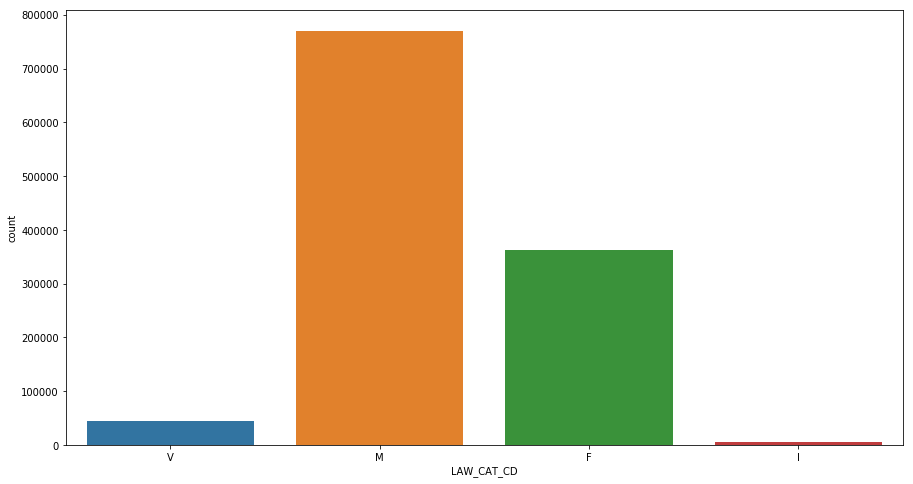

In [67]:
plt.figure(figsize=(15,8))
sns.countplot('LAW_CAT_CD', data=crime_1518)

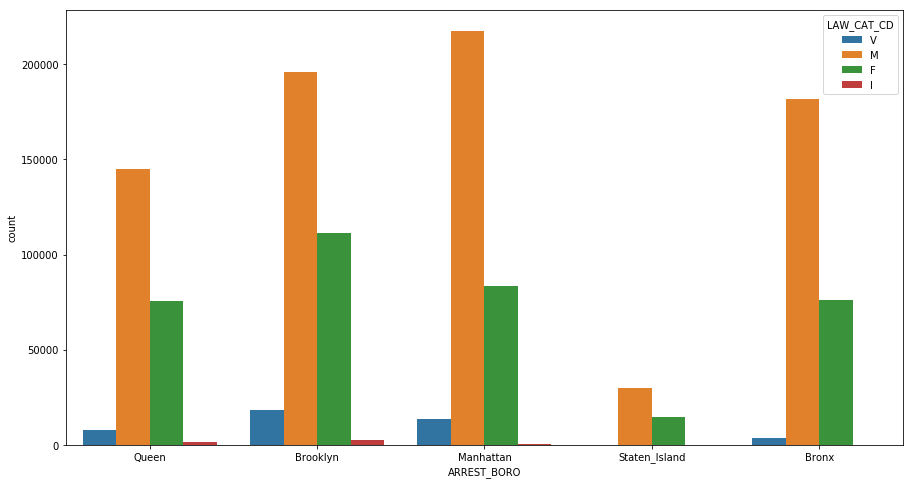

In [66]:
# # The number of arrest for the level of offense in each borough in NYC
plt.figure(figsize=(15,8))
sns.countplot(x=crime_1518['ARREST_BORO'],data=crime_1518, hue=crime_1518['LAW_CAT_CD'])

<a id='3.7'></a>
### 3.7. The number of arrest for the level of offense 

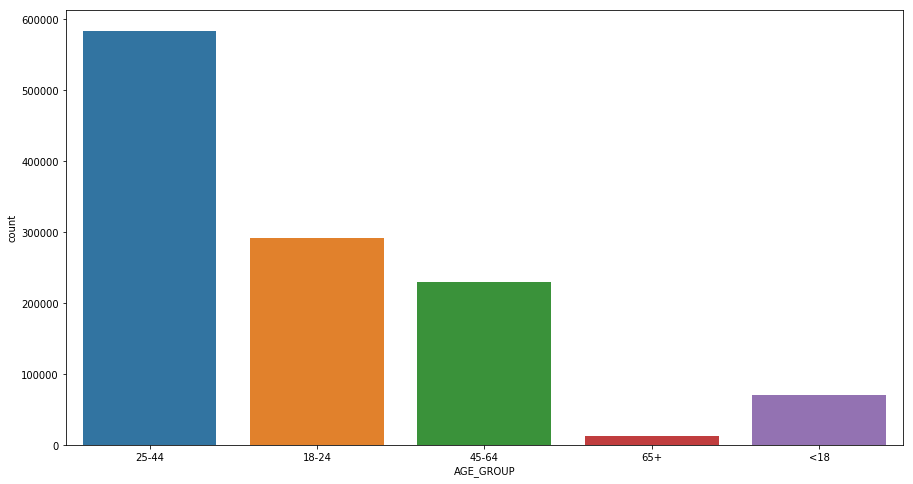

In [75]:

plt.figure(figsize=(15,8))
sns.countplot(x='AGE_GROUP', data=crime_1518)